In [8]:
import os

os.chdir('..')

In [9]:
import torch, gc, time
from bs4 import BeautifulSoup
from datasets import load_dataset
from torchmetrics.text import EditDistance
from IPython.display import display, HTML
from niteru import style_similarity, structural_similarity, similarity
from transformers import AutoProcessor, AutoModelForVision2Seq, AutoModel, AutoTokenizer, Pix2StructForConditionalGeneration

def clean_gpu_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

# Load dataset

In [10]:
ds = load_dataset('apoidea/pubtabnet-html', streaming=True)
test = ds['validation']

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

613565


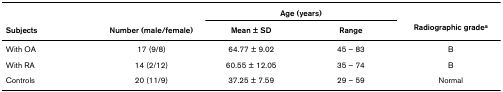

In [11]:
sample = next(iter(test))
print(sample['imgid'])
sample['image']

In [15]:
display(HTML(sample['html_table']))

# Define metrics

In [ ]:
ed_distance = EditDistance()

def extract_table_text(html):
    """Extracts only the text from an HTML table in row-wise space-separated format."""
    soup = BeautifulSoup(html, "html.parser")
    table = soup.find("table")  # Find the first table
    if not table:
        return ""

    # Extract rows and join cells with spaces
    return "\n".join(" ".join(cell.get_text(strip=True) for cell in row.find_all(["th", "td"])) for row in table.find_all("tr"))


def html_similarity(html1, html2):
    # Compute individual similarity scores
    style_sim = style_similarity(html1, html2)  # Assume returns [0,1]
    struct_sim = structural_similarity(html1, html2)  # Assume returns [0,1]
    txt1, txt2 = extract_table_text(html1), extract_table_text(html2)
    content_sim = 1 - (ed_distance(txt1, txt2) /
                                   max(len(txt1), len(txt2) + 1e-10))  # Avoid division by zero
    # Weighted sum of the similarities
    final_score = (0.10 * style_sim) + (0.50 * struct_sim) + (0.40 * content_sim)

    # Ensure final score is in [0,1]
    final_score = max(0, min(1, final_score))

    print(f"Style similarity: {style_sim:.4f}")
    print(f"Structural similarity: {struct_sim:.4f}")
    print(f"Lev-Edit Distance: {content_sim:.4f}")
    print(f"Final HTML Similarity Score: {final_score:.4f}")

    return final_score

# Granite Vision (2.98B)

In [7]:
model_path = "ibm-granite/granite-vision-3.2-2b"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
# Prepare image and text prompt, using the appropriate prompt template
processor = AutoProcessor.from_pretrained(model_path, use_fast=True)
model = AutoModelForVision2Seq.from_pretrained(
    model_path,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation="flash_attention_2"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
# Predict both images
def predict(img):
    # Prepare prompt
    conversation = [
        {
          "role": "system",
          "content": [
              {"type": "text", "text": "Convert the user's image to HTML."}
            ]
        },
        {
            "role": "user",
            "content": [
                {"type": "image"}
            ],
        },
    ]
    text = processor.apply_chat_template(conversation,
        add_generation_prompt=True,
    )
    inputs = processor(images=[img], text=text, return_tensors="pt").to(device)
    output = model.generate(**inputs, max_new_tokens=1500)
    output = processor.decode(output[0], skip_special_tokens=True)
    return output.split('<|assistant|>')[-1].strip()

In [10]:
%timeit
html = predict(sample['image'])
display(HTML('<table>' + html + '</table>'))

In [11]:
html_similarity('<table>' + html + '</table>', sample['html_table'])

Style similarity: 1.0000
Structural similarity: 0.0444
Lev-Edit Distance: 0.0000
Final HTML Similarity Score: 0.1222


tensor(0.1222)

# Fine-tuned Granite model

In [12]:
del model
clean_gpu_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 5.73 GB


In [13]:
from src.models.granite_vision.transformers_library import LLM as granite_vision

model = granite_vision(
    model_path,
    adapter='lang_only'
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded
Adapter 'lang_only' loaded
Adapter 'lang_only' merged
Using cuda: NVIDIA GeForce RTX 4070 Ti SUPER


In [14]:
%timeit
html = model.predict(sample['image'], max_new_tokens=1024, query="Convert table to HTML")
display(HTML(html))

In [15]:
html_similarity(html, sample['html_table'])

Style similarity: 1.0000
Structural similarity: 1.0000
Lev-Edit Distance: 0.9856
Final HTML Similarity Score: 0.9943


tensor(0.9943)

# OCR2 (716M)

In [ ]:
clean_gpu_memory()

Current:
GPU allocated memory: 5.58 GB
GPU reserved memory: 6.05 GB
--------------------------------------------------
After:
GPU allocated memory: 0.01 GB
GPU reserved memory: 5.73 GB


In [35]:
model_path = 'ucaslcl/GOT-OCR2_0'
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModel.from_pretrained(model_path, trust_remote_code=True, low_cpu_mem_usage=True, device_map='cuda', use_safetensors=True)
model.generation_config.pad_token_id = tokenizer.pad_token_id
model = model.eval().cuda()

In [36]:
html = model.chat(
    tokenizer,
    gradio_input=True,
    image_file=sample['image'],
    ocr_type='format'
)
print(html)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


\begin{tabular}{|c|c|c|c|c|}
\hline \multirow[b]{2}{*}{ Subjects } & \multirow[b]{2}{*}{ Number (male/female) } & \multicolumn{2}{|c|}{ Age (years) } & \multirow[b]{2}{*}{ Radiographic grade* } \\
\hline & & Mean \(\pm S D\) & Range & \\
\hline With OA & \(17(91 / 8)\) & \(84.77 \pm 9.02\) & \(45-83\) & B \\
\hline With RA & \(14(2 / 12)\) & \(60.55 \pm 12.05\) & \(35-74\) & B \\
\hline Controls & \(20(11 / 9)\) & \(37.25 \pm 7.59\) & \(29-59\) & Normal \\
\hline
\end{tabular}


In [37]:
html_similarity(html, sample['html_table'])

Style similarity: 0.0000
Structural similarity: 0.0000
BLEU: 0.0000
Final HTML Similarity Score: 0.0000


0

# Table2HTML (282M)

In [ ]:
clean_gpu_memory()

In [22]:
model_path = "KennethTM/pix2struct-base-table2html"
processor = AutoProcessor.from_pretrained(model_path)
model = Pix2StructForConditionalGeneration.from_pretrained(model_path)
model.to(device)
model.eval()

Pix2StructForConditionalGeneration(
  (encoder): Pix2StructVisionModel(
    (embeddings): Pix2StructVisionEmbeddings(
      (patch_projection): Linear(in_features=768, out_features=768, bias=True)
      (row_embedder): Embedding(4096, 768)
      (column_embedder): Embedding(4096, 768)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): Pix2StructVisionEncoder(
      (layer): ModuleList(
        (0-11): 12 x Pix2StructVisionLayer(
          (attention): Pix2StructVisionAttention(
            (query): Linear(in_features=768, out_features=768, bias=False)
            (key): Linear(in_features=768, out_features=768, bias=False)
            (value): Linear(in_features=768, out_features=768, bias=False)
            (output): Linear(in_features=768, out_features=768, bias=False)
          )
          (mlp): Pix2StructVisionMlp(
            (wi_0): Linear(in_features=768, out_features=2048, bias=False)
            (wi_1): Linear(in_features=768, out_features=2048, bias=False)
 

In [23]:
def predict(img):
    encoding = processor(img, return_tensors="pt", max_patches=1024, legacy=False)
    with torch.inference_mode():
        flattened_patches = encoding.pop("flattened_patches").to(device)
        attention_mask = encoding.pop("attention_mask").to(device)
        predictions = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask, max_new_tokens=1024)

    return processor.tokenizer.batch_decode(predictions, skip_special_tokens=True)[0]

In [24]:
html = predict(sample['image'])
display(HTML(html))

Keyword argument `legacy` is not a valid argument for this processor and will be ignored.


In [25]:
html_similarity(html, sample['html_table'])

Style similarity: 1.0000
Structural similarity: 0.9398
Lev-Edit Distance: 1.0000
Final HTML Similarity Score: 0.9699


tensor(0.9699)

In [28]:
clean_gpu_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 5.73 GB


# Llama Vision 11B

In [32]:
from src.models.llama.watsonxai import LLM as LlamaVision

model_name = "meta-llama/llama-3-2-11b-vision-instruct"
model = LlamaVision(model_name)

In [33]:
%timeit
html = model.predict(sample['image'], max_new_tokens=1024, query="Convert table to HTML")
display(HTML(html))

Subjects,Number (male/female),Mean ± SD,Age (years),Radiographic grade*
With OA,17 (9/6),64.77 ± 9.02,45 – 80,B
With RA,14 (2/12),60.55 ± 12.05,35 – 74,B
Controls,20 (11/9),37.25 ± 7.59,29 – 59,Normal
